<a href="https://colab.research.google.com/github/animesh-rai/x23194545_Sensitive_data_detection/blob/main/Sensitive_Data_Detection%20-%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive to the Colab environment to access external files and datasets.
* Facilitates access to external datasets and the saving of models.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Description

The dataset comprises approximately 22,000 essays written by students.
A majority of the essays are reserved for the test set (70%)

#### PII Entities
* NAME_STUDENT - The full or partial name of a student that is not necessarily the author of the essay. This excludes instructors, authors, and other person names.
* EMAIL - A student’s email address.
* USERNAME - A student's username on any platform.
* ID_NUM - A number or sequence of characters that could be used to identify a student, such as a student ID or a social security number.
* PHONE_NUM - A phone number associated with a student.
* URL_PERSONAL - A URL that might be used to identify a student.
* STREET_ADDRESS - A full or partial street address that is associated with the student, such as their home address.

#### File and Field Information
The data is presented in JSON format.
The documents were tokenized using the SpaCy English tokenizer.

Token labels are presented in BIO (Beginning, Inner, Outer) format. (e.g.: Waseem Mabunda and Emily -> B-NAME_STUDENT, I-NAME_STUDENT, O, B-NAME_STUDENT)

{test|train}.json - the test and training data; the test data given on this page is for illustrative purposes only, and will be replaced during Code rerun with a hidden test set.

(int): the index of the essay
document (int): an integer ID of the essay

full_text (string): a UTF-8 representation of the essay
tokens (string): a string representation of each token (list)

trailing_whitespace (bool): a boolean value indicating whether each token is followed by whitespace (list)

labels (string) [training data only]: a token label in BIO format (list)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import chain

In [ ]:
import datasets
# Load dataset
dataset = datasets.load_dataset('json', data_files='/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/train.json')
# Convert to DataFrame and preprocess
df = dataset['train'].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 266.0+ KB


In [ ]:
# Check if the number of tokens and labels are equal in the training dataset
is_equal = all(len(tokens) == len(labels) for tokens, labels in zip(df['tokens'], df['labels']))

if is_equal:
    print("Number of tokens and labels are equal.")
else:
    print("Number of tokens and labels are NOT equal.")


Number of tokens and labels are equal.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    # Calculate the value counts for the target column
    value_counts = data[target_column].value_counts(sort=False).reset_index()
    value_counts.columns = [target_column, 'total']
    total_sum = value_counts['total'].sum()

    # Plot the bar chart
    ax = sns.barplot(
        data=value_counts,
        x=target_column,
        y='total',
        palette='cool'
    )

    plt.tight_layout()
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title, fontweight='bold')
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', labelsize=9)

    # Display percentage on each bar
    for index, row in value_counts.iterrows():
        percentage = (row['total'] / total_sum) * 100
        ax.text(index, row['total'] + total_sum * 0.01, f'{percentage:.2f}%', ha='center', fontsize=9)

    plt.show()

def plot_non_pii_entity_doc(df):
    # Determine if a document contains only 'O' labels
    df['non_pii_entity_only'] = df['labels'].apply(lambda x: all(label == 'O' for label in x))

    # Plot the percentage of documents with only 'O' labels
    plot_bar_chart(
        data=df,
        target_column='non_pii_entity_only',
        title="Percentage of Documents with Non-PII Entity Only ('O' Label)",
        xlabel="Non PII Entity Only",
        ylabel="Frequency"
    )

    # Print the counts of documents
    print(df['non_pii_entity_only'].value_counts())


<ipython-input-9-a8c46be14bf6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


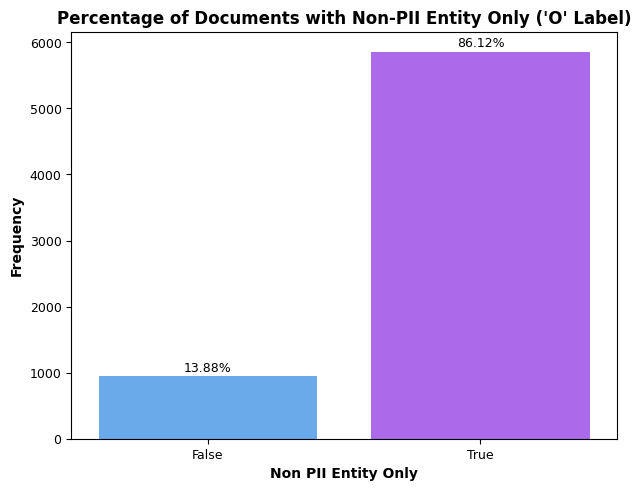

non_pii_entity_only
True     5862
False     945
Name: count, dtype: int64


In [ ]:
# check the distribution for non-PII entity, i.e. 'O' label
plot_non_pii_entity_doc(df)

In [ ]:
# Count label occurrences in the training data
label_counts = df['labels'].explode().value_counts()
label_counts = label_counts.to_dict()  # Convert to dictionary for a similar format as Counter
label_counts


{'O': 4989794,
 'B-NAME_STUDENT': 1365,
 'I-NAME_STUDENT': 1096,
 'B-URL_PERSONAL': 110,
 'B-ID_NUM': 78,
 'B-EMAIL': 39,
 'I-STREET_ADDRESS': 20,
 'I-PHONE_NUM': 15,
 'B-USERNAME': 6,
 'B-PHONE_NUM': 6,
 'B-STREET_ADDRESS': 2,
 'I-URL_PERSONAL': 1,
 'I-ID_NUM': 1}

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_label_distribution(df):
    # Flatten the labels column into a single list
    all_labels = [label for labels in df['labels'] for label in labels]
    label_counts = Counter(all_labels)

    # Exclude the "O" label and prepare sorted labels and counts
    filtered_labels = {label: count for label, count in label_counts.items() if label != 'O'}
    sorted_labels, sorted_counts = zip(*sorted(filtered_labels.items(), key=lambda x: x[1], reverse=True))



    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(sorted_labels, sorted_counts, color='skyblue')

    # Add counts on each bar
    for bar, count in zip(bars, sorted_counts):
        ax.text(
            bar.get_width() + 0.5,  # Position to the right of the bar
            bar.get_y() + bar.get_height() / 2,  # Centered vertically on the bar
            str(count),
            ha='left',
            va='center',
            fontsize=9
        )

    # Add labels and title
    ax.set_xlabel('Count', fontweight='bold')
    ax.set_ylabel('Label', fontweight='bold')
    ax.set_title('Distribution of Labels (Excluding "O")', fontweight='bold')
    plt.tight_layout()
    plt.show()




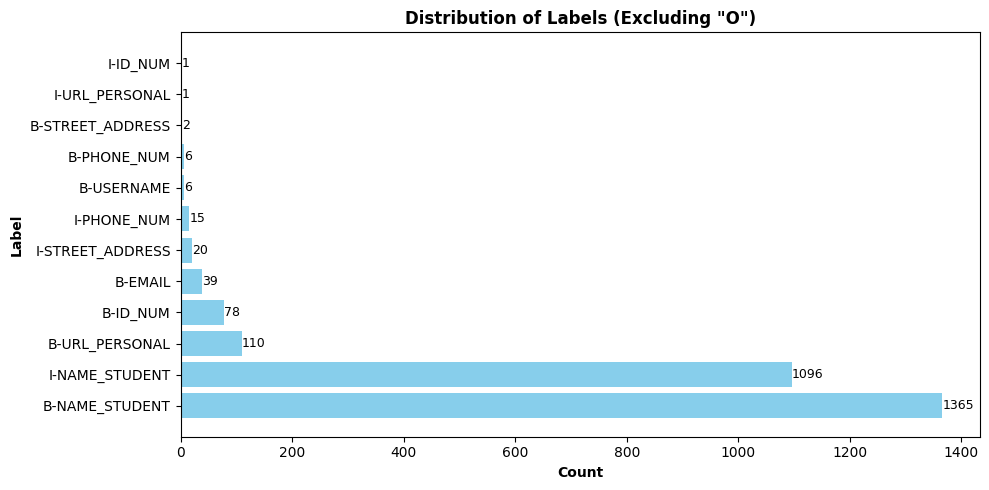

'O' label (in percentage): 99.95


In [ ]:
plot_label_distribution(df)
# Print the percentage of "O" labels
total_labels = sum(label_counts.values())
o_percentage = (label_counts['O'] / total_labels) * 100
print(f"'O' label (in percentage): {o_percentage:.2f}")

#### Observations:
The training dataset exhibits class imbalance:

* 86.12% of the documents contain only non-PII entities, represented by the 'O' label.
* 99.95% of the labels in the dataset are non-PII entities ('O' label).
The labels 'B-NAME_STUDENT' and 'I-NAME_STUDENT' associated with the entity 'NAME_STUDENT' appear more frequently than other entity labels, except for the 'O' label.

#### Recommendations:
* Data Collection: Augment the dataset by collecting additional samples to increase the representation of entities such as 'ID_NUM', 'EMAIL', 'URL_PERSONAL', 'PHONE_NUM', and 'STREET_ADDRESS'.

* Class Balancing: Apply downsampling techniques to reduce the prevalence of the 'O' label and mitigate the class imbalance.

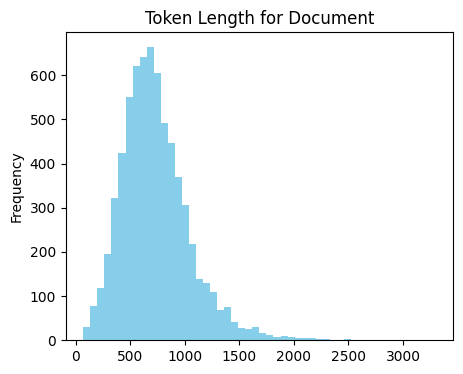

,token_len
count,6807.000000
mean,733.441017
std,319.244697
min,69.000000
25%,520.000000
50%,693.000000
75%,897.000000
max,3298.000000


In [ ]:
# check token length
df['token_len'] = df['tokens'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
df['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document")
plt.grid(False)
plt.show()

df['token_len'].describe()

In [ ]:
import pandas as pd
from sklearn.utils import resample


# Flatten the labels column to calculate class distribution
all_labels = [label for labels in df['labels'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()

# Target number of samples for each class (adjust as needed for better balance)
target_samples_per_class = 1500 // len(label_counts)

# Balance the dataset
balanced_data = []
for label in label_counts.index:
    class_data = df[df['labels'].apply(lambda x: label in x)]
    sampled_data = resample(
        class_data,
        replace=True if len(class_data) < target_samples_per_class else False,
        n_samples=target_samples_per_class,
        random_state=42
    )
    balanced_data.append(sampled_data)

# Combine all sampled data
balanced_df = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset
#balanced_df.to_csv('balanced_dataset.csv', index=False)

# Verify the balance
print(balanced_df['labels'].explode().value_counts())


labels
O                   1163712
I-STREET_ADDRESS       2660
B-NAME_STUDENT         1622
I-NAME_STUDENT         1579
I-PHONE_NUM            1068
B-URL_PERSONAL          601
B-EMAIL                 580
B-PHONE_NUM             488
B-ID_NUM                434
B-STREET_ADDRESS        266
B-USERNAME              140
I-ID_NUM                118
I-URL_PERSONAL          118
Name: count, dtype: int64


In [ ]:
balanced_df.head()

,document,full_text,tokens,trailing_whitespace,labels,non_pii_entity_only,token_len
0,7786,CHALLENGE\n\nBeing a part of an international ...,"[CHALLENGE, \n\n, Being, a, part, of, an, inte...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",False,626
1,19280,Learning Launch based on Design Thinking for I...,"[Learning, Launch, based, on, Design, Thinking...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",False,860
2,9854,Waseem Mabunda 591 Smith Centers Apt. 656\nJo...,"[Waseem, Mabunda, , 591, Smith, Centers, Apt,...","[True, True, False, True, True, True, False, T...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...",False,707
3,4381,"WRITING CENTRE Level 3 East, Hub Central Nor...","[WRITING, CENTRE, , Level, 3, East, ,, Hub, C...","[True, True, False, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",False,1222
4,11442,Reflection – Learning Launch of 1861. Milano\n...,"[Reflection, –, Learning, Launch, of, 1861, .,...","[True, True, True, True, True, False, True, Fa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",False,1210


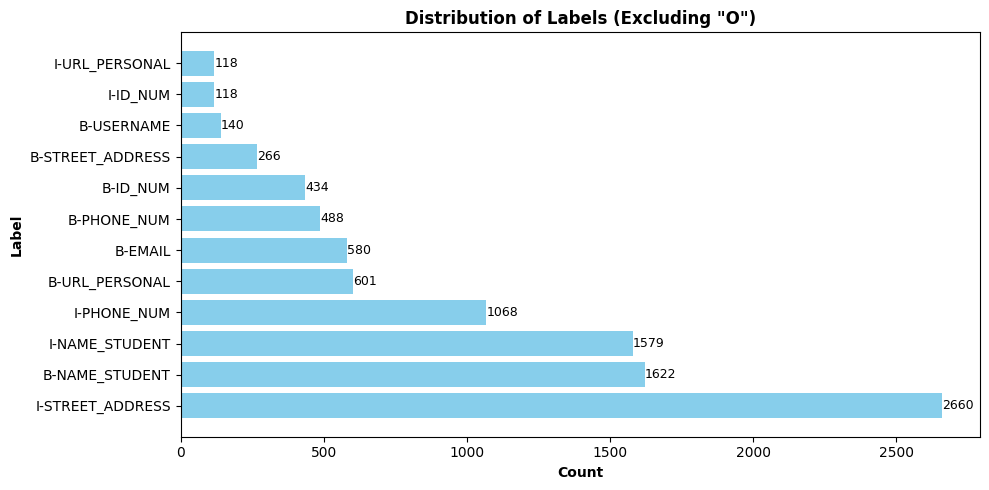

In [ ]:
plot_label_distribution(balanced_df)

 The dataset for the PII detection task is highly imbalanced. The 'O' label (non-PII) dominates the dataset with 1,163,712 occurrences, while the PII-related labels have much lower frequencies. This imbalance can lead to the model being biased towards predicting the 'O' label, which is not ideal for a PII detection task.

#### Observations:
* Dominance of 'O' Label: 'O' label accounts for the vast majority of the dataset, making it likely that the model will overfit to non-PII entities.
* Significant Imbalance: PII-related entities like 'B-EMAIL', 'B-PHONE_NUM', 'B-ID_NUM', and 'B-STREET_ADDRESS' have much lower representation compared to the 'O' label.
* Sufficient Samples for Some PII Labels: Labels like 'I-STREET_ADDRESS' and 'B-NAME_STUDENT' have a reasonable count, but their occurrence is still small relative to 'O'.

#### what I can do:
* Downsample the 'O' Label: Reduce the number of 'O' label samples to balance the dataset without removing too much data.

* Upsample Rare PII Labels: Use oversampling techniques to duplicate instances of underrepresented PII labels, ensuring sufficient representation in the training set.
* Data Augmentation: Augment the existing PII samples using techniques such as paraphrasing, adding synthetic data, or applying transformations.
* Class Weighting: During training, apply class weights to penalize the model more heavily for incorrect predictions on rare classes, ensuring better detection of PII.

<ipython-input-48-a8c46be14bf6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


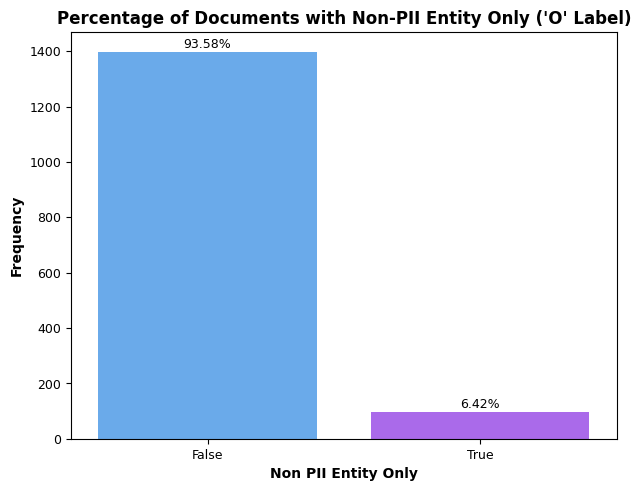

non_pii_entity_only
False    1399
True       96
Name: count, dtype: int64


In [ ]:
# check the distribution for non-PII entity, i.e. 'O' label
plot_non_pii_entity_doc(balanced_df)

In [ ]:
len(balanced_df)

1495

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Flatten labels to calculate class distribution
all_labels = [label for labels in df['labels'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()
print("Original Label Distribution:\n", label_counts)

# Define unique labels
unique_labels = set(all_labels)

# Define the target number of rows
total_rows = 1500
target_per_class = total_rows // len(label_counts)

# Downsample the 'O' label to reduce dominance
majority_class = df[df['labels'].apply(lambda x: 'O' in x)]
downsampled_majority = resample(
    majority_class,
    replace=False,
    n_samples=200,  # Limit the 'O' label to a small count
    random_state=42
)

# Upsample rare PII labels to improve representation
balanced_data = [downsampled_majority]
for label in unique_labels:
    if label != 'O':
        class_data = df[df['labels'].apply(lambda x: label in x)]
        upsampled_data = resample(
            class_data,
            replace=True,
            n_samples=100 if len(class_data) < 100 else len(class_data),
            random_state=42
        )
        balanced_data.append(upsampled_data)

# Combine balanced data
balanced_df = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

# Save and inspect
#final_balanced_df.to_csv('balanced_pii_dataset.csv', index=False)
print("Balanced Label Distribution:")
print(pd.Series([label for labels in balanced_df['labels'] for label in labels]).value_counts())
print(f"Total Rows: {len(balanced_df)}")


Original Label Distribution:
 O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64
Balanced Label Distribution:
O                   2336047
B-NAME_STUDENT         3616
I-NAME_STUDENT         3306
I-STREET_ADDRESS       2340
I-PHONE_NUM             891
B-URL_PERSONAL          597
B-EMAIL                 542
B-ID_NUM                486
B-PHONE_NUM             419
B-STREET_ADDRESS        234
B-USERNAME              125
I-URL_PERSONAL          104
I-ID_NUM                100
Name: count, dtype: int64
Total Rows: 2905


In [ ]:
balanced_df.head()

,document,full_text,tokens,trailing_whitespace,labels,non_pii_entity_only,token_len
0,15513,Challenge\n\nTo better and more efficiently me...,"[Challenge, \n\n, To, better, and, more, effic...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True,925
1,10494,Ahmed Elnemr // Reflection – Learning Launch\n...,"[Ahmed, Elnemr, //, Reflection, –, Learning, L...","[True, True, True, True, True, True, False, Fa...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...",False,977
2,3202,Final Assignment\n\nUniversity of Virginia's D...,"[Final, Assignment, \n\n, University, of, Virg...","[True, False, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",False,293
3,5494,Francesco Sanchez\n\nChallenge and Selection\n...,"[Francesco, Sanchez, \n\n, Challenge, and, Sel...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...",False,799
4,12705,ASSIGNMENT- Design Thinking\n\nNadeem Pandey\n...,"[ASSIGNMENT-, Design, Thinking, \n\n, Nadeem, ...","[True, True, False, False, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...",False,1025


In [ ]:
import json
# List of original columns in `df`
original_columns = ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels']

# Retain only the columns that are in the original `df`
balanced_df = balanced_df[original_columns]

# Verify the columns in the dataset
print(balanced_df.info())

# Ensure the 'labels' column is converted to a list
balanced_df['labels'] = balanced_df['labels'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Save the 'labels' column as JSON strings
balanced_df['labels'] = balanced_df['labels'].apply(json.dumps)


# Save the cleaned dataset
balanced_df.to_csv('balanced_pii_dataset.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             2905 non-null   int64 
 1   full_text            2905 non-null   object
 2   tokens               2905 non-null   object
 3   trailing_whitespace  2905 non-null   object
 4   labels               2905 non-null   object
dtypes: int64(1), object(4)
memory usage: 113.6+ KB
None


In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/Dataset/balanced_PII_dataset.csv')
balanced_df.head()

,document,full_text,tokens,trailing_whitespace,labels,non_pii_entity_only,token_len
0,8642,Basavaraju Aakash Kumar\n\nboydcynthia@yahoo.c...,['Basavaraju' 'Aakash' 'Kumar' '\n\n' 'boydcyn...,[ True True False False True False True Fal...,['B-NAME_STUDENT' 'I-NAME_STUDENT' 'I-NAME_STU...,False,493
1,11409,Final Assignment – “Design Thinking for Innova...,['Final' 'Assignment' '–' '“' 'Design' 'Thinki...,[ True True True False True True True Fal...,['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-NA...,False,867
2,5716,ID meyermichelle\n\nReflection\n\nThe first to...,['ID' 'meyermichelle' '\n\n' 'Reflection' '\n\...,[ True False False False False True True Tr...,['O' 'B-USERNAME' 'O' 'O' 'O' 'O' 'O' 'O' 'O' ...,False,876
3,4501,Free time\n\nand the\n\nelderly\n\nBefriending...,['Free' 'time' '\n\n' 'and' 'the' '\n\n' 'elde...,[ True False False True False False False Fal...,['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' '...,False,569
4,12876,Visualization\n\nAna Perez Challenge & Select...,['Visualization' '\n\n' 'Ana' ... 'work' '.' '...,[False False True ... False False False],['O' 'O' 'B-NAME_STUDENT' ... 'O' 'O' 'O'],False,1015


* Class Separation: The majority class ('O') is separated and downsampled to reduce its dominance.
Minority classes (PII-related labels) are separated for processing.
* Downsampling: Reduced the number of 'O' label samples to the target per class.
* Upsampling: Minority classes are upsampled (duplicated) to match the target per class for better balance.
* Combination: Combined all the balanced data and shuffled them to create the final dataset.

Output: Saves the balanced dataset as balanced_dataset.csv.
Prints the new label distribution to verify balance.

* Benefits: Ensures sufficient representation of all PII-related labels.
Reduces bias towards the 'O' label.
Prepares a balanced dataset with 1500 rows for NER training.